# **Random Forest Classifier**

# **Random Forest Classifier**

In [24]:
import pandas as pd

In [25]:
train_data = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

In [26]:
print(f"Number of data points in the training set: {train_data.shape[0]}")
print(f"Number of data points in the test set: {test_data.shape[0]}")

Number of data points in the training set: 373598
Number of data points in the test set: 35406


In [27]:
columns_to_drop = ['_url', 'name',  'profile', 'length',
                            'startlist_quality', 'position', 'cyclist', 'cyclist_team', 
                            'duration', 'cyclist_experience_profile',
                            'cyclist_experience_length', 'cyclist_experience_climb', 
                            'avg_rel_position_length', 'avg_rel_position_climb', 
                            'relative_position_sum', 'relative_position',
                            "climb_cat", "length_cat", "cyclist_number", 
                            "avg_rel_position_profile", "points", 'is_tarmac', 
                            'avg_cyclist_level']

train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [28]:
train_data.columns

Index(['climb_total', 'cyclist_age', 'cyclist_level', 'cyclist_experience',
       'avg_relative_position', 'position_entropy', 'top_20_entropy'],
      dtype='object')

## Preprocessing Pipeline

In [29]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline 

In [30]:
cat_features = [col for col in ['is_tarmac', 'length_cat', 'climb_cat'] if col not in columns_to_drop]
# Define the preprocessing for numeric and categorical features
numeric_features = [col for col in train_data.columns if col not in cat_features]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', "passthrough", cat_features)
    ])

## Decision Tree Model

In [31]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, average_precision_score,  confusion_matrix, get_scorer, make_scorer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, get_scorer, make_scorer
from imblearn.combine import SMOTEENN,  SMOTETomek
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import sensitivity_score, specificity_score, precision_with_zero_division, recall_with_zero_division

In [32]:
resampling = SMOTETomek(sampling_strategy=0.9, random_state=42)
#train_data, train_labels = resampling.fit_resample(train_data, train_labels)

clf = LGBMClassifier(boosting_type='rf', is_unbalance=True, importance_type='gain', verbose=-1, random_state=0, n_jobs=1)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resampling", resampling),
        ("clf", clf)]
)

params = {
        'clf__boosting_type': ['gbdt'],
        'clf__n_estimators': [50, 60, 70, 80, 90, 100, 120, 150, 170],
        'clf__learning_rate': [0.0001, 0.0005, 0.001, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'clf__max_depth': [2, 3, 4, 5],
        'clf__reg_lambda': [0.0001, 0.005, 0.001, 0.005, 0.01, 0.1, 0.3, 0.5, 0.7],
        'clf__reg_alpha': [0.001, 0.005, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7],
        'clf__max_bins': [4, 8, 16, 32, 64, 128, 255],
        'clf__min_child_samples': [5, 10, 15, 20],
        'clf__is_unbalance': [False],
        'clf__importance_type': ['gain'],
        'clf__verbose': [-1],
        'clf__random_state': [0],
        'clf__n_jobs': [1]
}


scoring = {
    'sensitivity': make_scorer(sensitivity_score),
    'specificity': make_scorer(specificity_score),
    'accuracy': get_scorer("accuracy"),
    'precision': make_scorer(precision_with_zero_division),
    'recall': make_scorer(recall_with_zero_division),
    'roc_auc': get_scorer("roc_auc"),
    'f1': get_scorer("f1")
}

# Perform randomized search cross-validation
rscv = RandomizedSearchCV(
    model, 
    param_distributions=params, 
    scoring=scoring,
    n_iter=25, 
    cv=5,   # already stratified!
    verbose=1, 
    n_jobs=-1, 
    random_state=42, 
    refit="f1"
    ) 

rscv.fit(train_data, train_labels.values.ravel())

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['climb_total',
                                                                                'cyclist_age',
                                                                                'cyclist_level',
                                                                                'cyclist_experience',
                                                                                'avg_relative_position',
                                                                                'position_entropy',
                                                                                'top_20_entropy']),
                                                                              ('cat',
                                                                               'passthrough',
                                                                               [])])),
                                             ('resampling',
                                              SMOTETomek(random_state=42,
                                                         sampling_strategy=0.9)),
                                             ('clf',...
                            'precision': make_scorer(precision_with_zero_division, response_method='predict'),
                            'recall': make_scorer(recall_with_zero_division, response_method='predict'),
                            'roc_auc': make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba')),
                            'sensitivity': make_scorer(sensitivity_score, response_method='predict'),
                            'specificity': make_scorer(specificity_score, response_method='predict')},
                   verbose=1)

## Model Assessment

### Validation scores:

In [33]:
# extract the results of the randomized search and best model idx
cv_results = rscv.cv_results_
best_index = rscv.best_index_

#extract and print matrics
mean_test_scores = {metric: cv_results[f'mean_test_{metric}'][best_index] for metric in scoring.keys()}
std_test_scores = {metric: cv_results[f'std_test_{metric}'][best_index] for metric in scoring.keys()}

print("Validation results of the best model:")
for metric in scoring.keys():
    print(f"{metric.capitalize()} - Mean: {mean_test_scores[metric]:.4f}, Std: {std_test_scores[metric]:.4f}")



Validation results of the best model:
Sensitivity - Mean: 0.5656, Std: 0.0055
Specificity - Mean: 0.8159, Std: 0.0014
Accuracy - Mean: 0.7826, Std: 0.0010
Precision - Mean: 0.3199, Std: 0.0018
Recall - Mean: 0.5656, Std: 0.0055
Roc_auc - Mean: 0.7678, Std: 0.0023
F1 - Mean: 0.4087, Std: 0.0026


### Test scores:

Accuracy: 0.739
Recall: 0.607
Precision: 0.304
Sensitivity: 0.607
Specificity: 0.762
F1 Score: 0.405
ROC AUC Score: 0.684


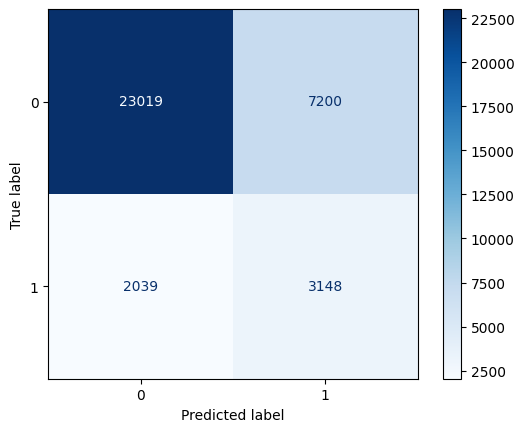

In [34]:
# Predict on the test data
test_predictions = rscv.predict(test_data)

# Calculate and visualize evaluation metrics
accuracy = round(accuracy_score(test_labels, test_predictions), 3)
recall = round(recall_with_zero_division(test_labels, test_predictions), 3)
precision = round(precision_with_zero_division(test_labels, test_predictions), 3)
sensitivity_score = round(sensitivity_score(test_labels, test_predictions), 3)
specificity_score = round(specificity_score(test_labels, test_predictions), 3)
f1 = round(f1_score(test_labels, test_predictions), 3)
roc_auc = round(roc_auc_score(test_labels, test_predictions), 3)
conf_matrix = confusion_matrix(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity_score}")
print(f"Specificity: {specificity_score}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [35]:
report = classification_report(test_labels, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.76      0.83     30219
           1       0.30      0.61      0.41      5187

    accuracy                           0.74     35406
   macro avg       0.61      0.68      0.62     35406
weighted avg       0.83      0.74      0.77     35406



In [36]:
# Get the best estimator from the RandomizedSearchCV
best_model = rscv.best_estimator_
best_dt = best_model.named_steps["clf"]

cat_transformer = rscv.best_estimator_.named_steps["preprocessor"].named_transformers_["cat"] 
cat_feature_names = [] if cat_transformer == 'passthrough' else cat_transformer.get_feature_names_out(cat_features)

all_features = numeric_features + cat_feature_names


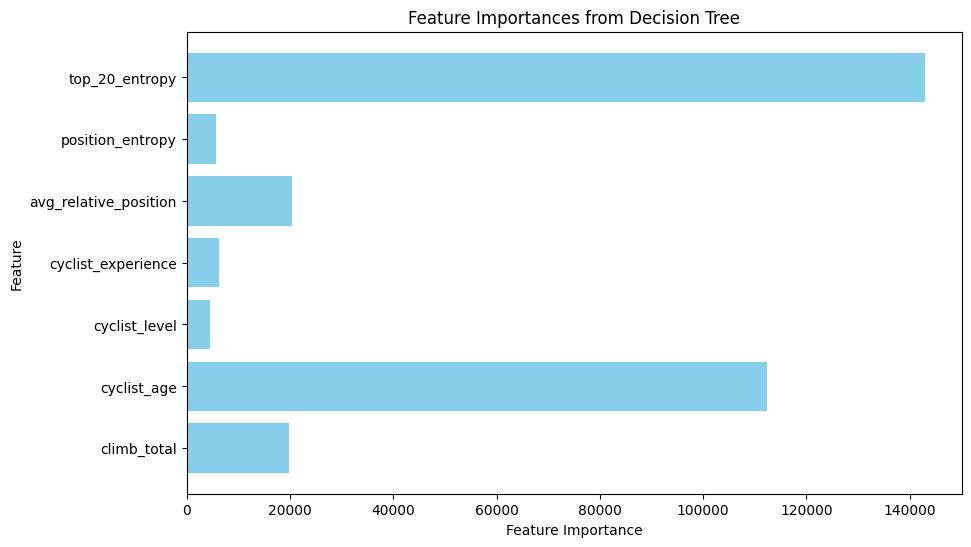

In [37]:
# Print feature importance
feature_importances = best_dt.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(all_features, feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Decision Tree')
plt.show()

In [38]:
import joblib
import os

# Create the directory if it doesn't exist
os.makedirs('best_models', exist_ok=True)
# Save the best model
joblib.dump(best_model, 'best_models/gbm.pkl')

['best_models/gbm.pkl']